In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import pdb
%matplotlib inline

In [148]:
# Load in Datasets
df_labels = pd.read_csv('moore_stroke_labels.csv')
df_demographics = pd.read_csv('moore_stroke_demographics.csv')
df_meds = pd.read_csv('moore_stroke_aspirin.csv')
df_comorbids = pd.read_csv('moore_stroke_afib.csv')
df_vitals = pd.read_csv('moore_stroke_vitals.csv')

## Feature Engineering
5 csv files here generated from sql queries on starr_datalake2018 which finds patient admitted to the ER who subsequently received a CT exam and were placed on tPA - and joins them to a serires of tables that contain potential predictor variables.   

### Demographics
* Age
* Sex
* Race (White, Black, Asian, Native American, Pacific Islander, Other)
* Ethnicity (Non-Hispanic, Hispanic/Latino)

### Comorbities
ICD9/10 codes from prior patient encounters. Looking specifically for history of atrial fibrillation. 
* Patient has history of afib (0 or 1)
* Days since last known afib dx. 

### Medications
Joined cohort to medication table to look at history of aspirin use. 
* Aspirin ordered during current encounter (0 or 1)
* Aspirin ordered at any point in patient history
    * Obviously patients can get aspirin over the counter and we wouldn't know about it, and they could get it at another insitution and we wouldn't know about it
* Days since last aspirin order (given patient has history of taking aspirin)

### Vitals
Joined to flowsheets and engineer presenting values for
* Systolic BP
* Diastolic BP
* Heart Rate
* Urine (Barely any datapoints)
* Temp
* Glasgow Coma Scale Score

In [149]:
# Generate label: Time from ER Admit to tPA administration 
df_labels['tpaAdminTime'] = pd.to_datetime(df_labels['tpaAdminTime'])
df_labels['emergencyAdmitTime']  = pd.to_datetime(df_labels['emergencyAdmitTime'])
df_labels['time_to_tPA'] = df_labels['tpaAdminTime'] - df_labels['emergencyAdmitTime']
df_labels['time_to_tPA'] = df_labels['time_to_tPA'].dt.seconds/60. # convert timedelta to min
df_labels = df_labels[['jc_uid', 'pat_enc_csn_id_coded', 'time_to_tPA']] # Keep useful columns

# Feature Engineer Demographics and Merge with Labels DataFrame
df_demographics['emergencyAdmitTime'] = pd.to_datetime(df_demographics['emergencyAdmitTime'])
df_demographics['birth_date_jittered']  = pd.to_datetime(df_demographics['birth_date_jittered'])
df_demographics['age'] = df_demographics['emergencyAdmitTime'] - df_demographics['birth_date_jittered']
df_demographics['age'] = df_demographics['age'].dt.days/365.
df_demographics = df_demographics[['jc_uid', 'pat_enc_csn_id_coded', 'age', 'gender', 'canonical_race', 'canonical_ethnicity']]
df_labels = pd.merge(df_labels, df_demographics, on=['jc_uid', 'pat_enc_csn_id_coded'], how='left')

# Feature Engineer History of Afib and time since last afib dx and merge with labels.
# CSV's should already be ordered by timestamp of ICD code, so okay to take last. 
df_comorbids = df_comorbids.groupby(['jc_uid', 'pat_enc_csn_id_coded']).last().reset_index()
df_comorbids['emergencyAdmitTime'] = pd.to_datetime(df_comorbids['emergencyAdmitTime'])
df_comorbids['timestamp'] = pd.to_datetime(df_comorbids['timestamp'])
df_comorbids['days_since_afib_dx'] = df_comorbids['emergencyAdmitTime'] - df_comorbids['timestamp']
df_comorbids['days_since_afib_dx'] = df_comorbids['days_since_afib_dx'].dt.days
df_comorbids = df_comorbids[['jc_uid', 'pat_enc_csn_id_coded', 'days_since_afib_dx']]
df_labels = pd.merge(df_labels, df_comorbids, on=['jc_uid', 'pat_enc_csn_id_coded'], how='left')
df_labels['history_of_afib'] = df_labels['days_since_afib_dx'].notna().astype(int)

# Feature Engineer Aspirin Ordered During ER admission
df_meds_admit = df_meds[df_meds['pat_enc_csn_id_coded'] == df_meds['med_enc']]
df_meds_admit = df_meds_admit[['jc_uid', 'pat_enc_csn_id_coded', 'med_description']].groupby(['jc_uid', 'pat_enc_csn_id_coded']).first().reset_index() # Don't care if multiple kinds of aspsirin ordered here so okay to just take first arbitrarily 
df_labels = pd.merge(df_labels, df_meds_admit, on=['jc_uid', 'pat_enc_csn_id_coded'], how='left')
df_labels['aspirin_ord_during_admit'] = df_labels['med_description'].notna().astype(int)
df_labels = df_labels.drop('med_description', axis=1)

# Feature Engineer History of Aspirin and merge to labels
df_meds = df_meds[df_meds['pat_enc_csn_id_coded'] != df_meds['med_enc']]
df_meds = df_meds.groupby(['jc_uid', 'pat_enc_csn_id_coded']).last().reset_index() # again csv should be ordered by timestamp, so just take last
df_meds['emergencyAdmitTime'] = pd.to_datetime(df_meds['emergencyAdmitTime'])
df_meds['order_time_jittered'] = pd.to_datetime(df_meds['order_time_jittered'])
df_meds['days_since_last_aspirin_order'] = df_meds['emergencyAdmitTime'] - df_meds['order_time_jittered']
df_meds['days_since_last_aspirin_order'] = df_meds['days_since_last_aspirin_order'].dt.days
df_meds = df_meds[['jc_uid', 'pat_enc_csn_id_coded', 'days_since_last_aspirin_order']]
df_labels = pd.merge(df_labels, df_meds, on=['jc_uid', 'pat_enc_csn_id_coded'], how='left')
df_labels['prior_asprin_order'] = df_labels['days_since_last_aspirin_order'].notna().astype(int)

# Feature Engineer Presenting vitals and merge to labels
df_vitals = df_vitals.groupby(['jc_uid', 'pat_enc_csn_id_coded', 'row_disp_name']).first().reset_index() # Get first of each Vital Type Upon each Admission 
df_vitals = df_vitals[['pat_enc_csn_id_coded', 'row_disp_name', 'meas_value']]
df_vitals = df_vitals.pivot(index='pat_enc_csn_id_coded', columns = 'row_disp_name', values='meas_value').reset_index() # Like spread in R
df_labels = pd.merge(df_labels, df_vitals, on=['pat_enc_csn_id_coded'], how='left')

# Convert BP To Systolic and Diastolic BP Features
def get_diastolic(x):
    if '/' in x:
        x = x.split('/')[0]
    else:
        x = None
    return x

def get_systolic(x):
    if '/' in x: 
        x = x.split('/')[1].split()[0]
    else:
        x = None
    return x

df_labels['Systolic_BP'] = df_labels['BP'].astype(str).map(get_diastolic).astype(float)
df_labels['Diastolic_BP'] = df_labels['BP'].astype(str).map(get_systolic).astype(float)

# Convert Urine to Float
df_labels['Urine'] = df_labels['Urine'].astype(str).map(lambda x : x.split()[0]).astype(float)

# Convert Temperature to Float (Some temperatures given in F and C so Just take F)
df_labels['Temp'] = df_labels['Temp'].astype(str).map(lambda x : x.split()[0]).astype(float)

# Convert Glasgow Coma  and Heart Rate to Float
df_labels['Glasgow Coma Scale Score'] = df_labels['Glasgow Coma Scale Score'].astype(float)
df_labels['Heart Rate'] = df_labels['Heart Rate'].astype(float)

### Distribution of Time From ER Admit to tPA Administration
Here we show the full distribution from the sql query cohort, and note that there exist a few outliers where time to tPA is much greater than the contraindication limit of 4.5 hours since start of stroke. We filter our data at this 4.5 hour cutoff, and the new distribution is displayed on the right

Text(0.5, 1.0, 'Time to tPA administration outliers removed')

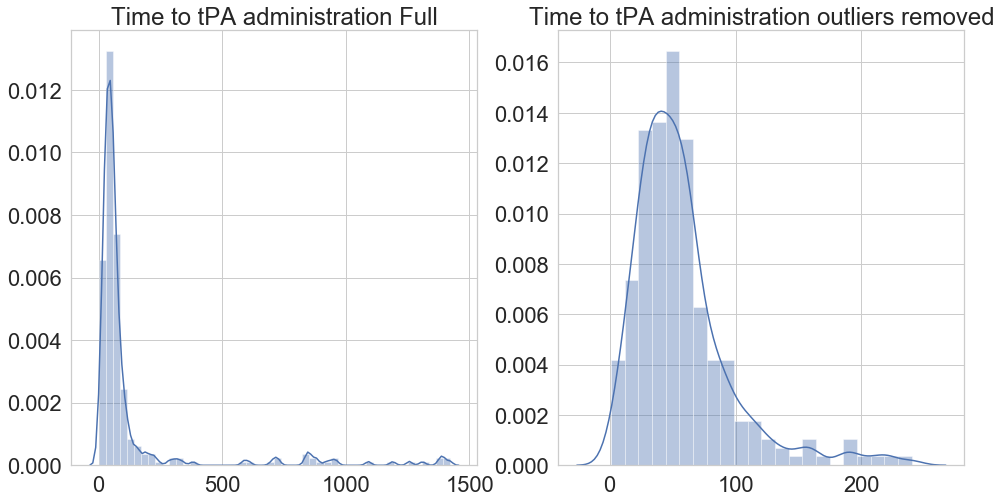

In [150]:
sns.set(style="whitegrid", font_scale=2.0)
times = df_labels['time_to_tPA'].values
fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(times)
ax1.set_title('Time to tPA administration Full')

df_labels = df_labels[df_labels['time_to_tPA'] < 60*4.5] # time_to_tPA should be less than 4.5 hours - filters outliers - how do we explain 
ax2 = plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_labels['time_to_tPA'].values)
ax2.set_title('Time to tPA administration outliers removed')

## Lets Create Some Plots of Time to tPA by Demographics

Lets look at age, sex, and ethnicity. Two tailed T-test used to get pvals for sex and ethnicity.  Regression line fit through age, pearsonr and corresponding pvalue shown in fig. Sex and ethnicity significant with p < 0.05.  Easy to make up stories post hoc... but added language barrier prevents consent of tPA admin?

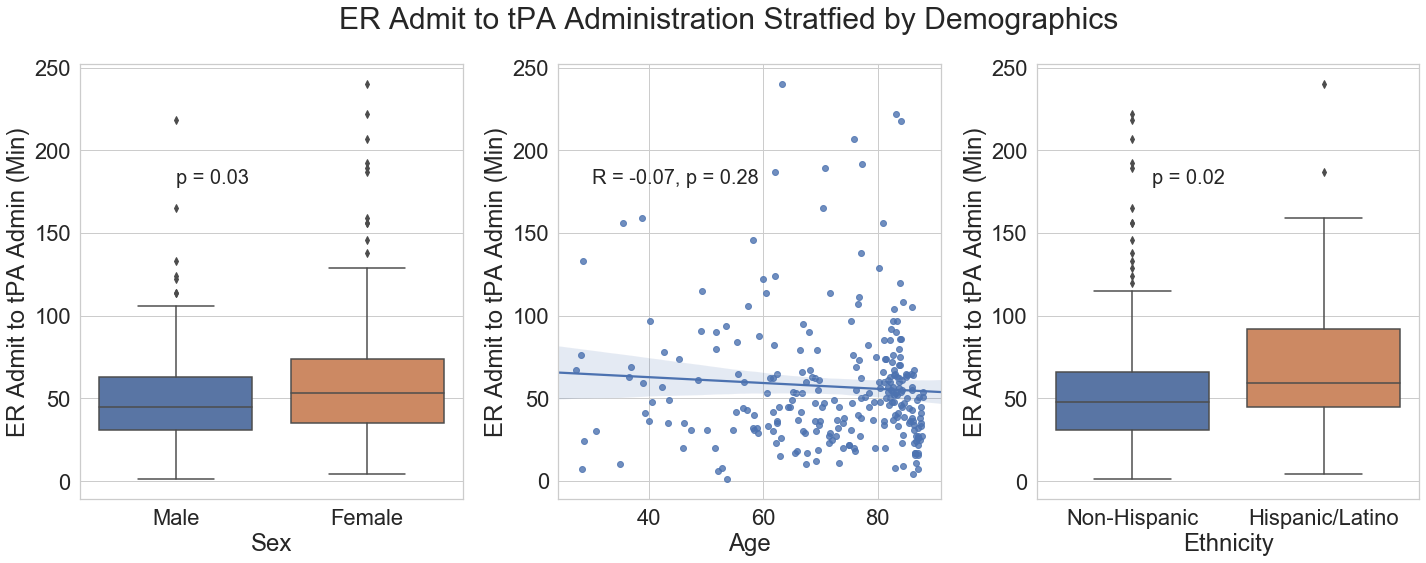

In [132]:

# Create figs
sns.set(style="whitegrid", font_scale=2.0)
fig1 = plt.figure(figsize=(24, 8))
fig1.suptitle('ER Admit to tPA Administration Stratfied by Demographics', fontsize=30)

ax1 = fig1.add_subplot(1, 3, 1)
ax1 = sns.boxplot(x="gender", y="time_to_tPA", data=df_labels)
df_male = df_labels[df_labels['gender'] == 'Male']
df_female = df_labels[df_labels['gender'] == 'Female']
t, p = ttest_ind(df_male['time_to_tPA'], df_female['time_to_tPA'])
ax1.text(0.0001, 180,'p = %.2f' % p, fontsize=20)
ax1.set_xlabel('Sex')
ax1.set_ylabel('ER Admit to tPA Admin (Min)')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax2 = fig1.add_subplot(1, 3, 2)
ax2 = sns.regplot(x="age", y="time_to_tPA", data=df_labels)
pearson, pval = pearsonr(df_labels['age'], df_labels['time_to_tPA'])
ax2.text(30, 180,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax2.set_xlabel('Age')
ax2.set_ylabel('ER Admit to tPA Admin (Min)')


# Ethnicity has 3 unique vals: Non-Hispanic, Hispanci, and Unknown. Filter out unknowns
df_no_unk = df_labels[df_labels['canonical_ethnicity'] != 'Unknown']
ax3 = fig1.add_subplot(1, 3, 3)
ax3 = sns.boxplot(x="canonical_ethnicity", y="time_to_tPA", data=df_no_unk)
no_hisp = df_no_unk[df_no_unk['canonical_ethnicity'] == 'Non-Hispanic']
hisp = df_no_unk[df_no_unk['canonical_ethnicity'] == 'Hispanic/Latino']
t, p = ttest_ind(no_hisp['time_to_tPA'], hisp['time_to_tPA'])
ax3.text(0.1, 180,'p = %.2f' % p, fontsize=20)
ax3.set_xlabel('Ethnicity')
ax3.set_ylabel('ER Admit to tPA Admin (Min)')

fig1.subplots_adjust(wspace=0.25)

## Now Lets look at Comorbities (Specifically History of Afib)

Will stratify by history of Afib and perform two tailed ttest to get pvalue.  Plot on left.  No significant difference.  Plot on right shows time till tPA admin by days since last dx of afib given there is a prior diagnosis of afib.  Not significant at p < 0.05 but downward trend. 

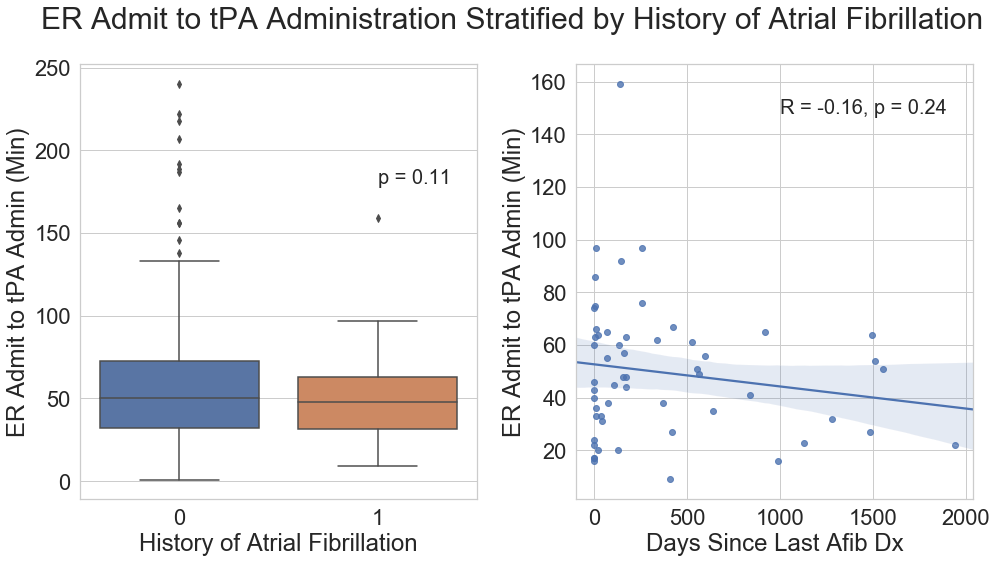

In [133]:
# Create figs
sns.set(style="whitegrid", font_scale=2.0)
fig1 = plt.figure(figsize=(16, 8))
fig1.suptitle('ER Admit to tPA Administration Stratified by History of Atrial Fibrillation', fontsize=30)

ax1 = fig1.add_subplot(1, 2, 1)
ax1 = sns.boxplot(x="history_of_afib", y="time_to_tPA", data=df_labels)
df_afib = df_labels[df_labels['history_of_afib'] == 1]
df_no_afib = df_labels[df_labels['history_of_afib'] ==  0]
t, p = ttest_ind(df_afib['time_to_tPA'], df_no_afib['time_to_tPA'])
ax1.text(1, 180,'p = %.2f' % p, fontsize=20)
ax1.set_xlabel('History of Atrial Fibrillation')
ax1.set_ylabel('ER Admit to tPA Admin (Min)')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

# Of the the people who had atrial fibrillation, does time since last atrial fibrillation matter?
ax2 = fig1.add_subplot(1, 2, 2)
ax2 = sns.regplot(x="days_since_afib_dx", y="time_to_tPA", data=df_afib)
pearson, pval = pearsonr(df_afib['days_since_afib_dx'], df_afib['time_to_tPA'])
ax2.text(1000, 148,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax2.set_xlabel('Days Since Last Afib Dx')
ax2.set_ylabel('ER Admit to tPA Admin (Min)')

fig1.subplots_adjust(wspace=0.25)

## Now Lets look at Prior Meds (Specifically Aspirin)

First plot - time till tPA treatment stratified by whether the presenting patient was given Aspirin.  Longer delay if given aspirin.  Middle plot shows time till tPA treamtent stratified by whether the presenting patient had been given aspirin in the past. Not significant at p < 0.05, though the pvalue is low.  Diff in means greater than diff in medians - suggesting tails are playing a key role in why the pvalue is relatively small. Right plot shows time till tPA by time since last known aspirin in days.  No trend. 

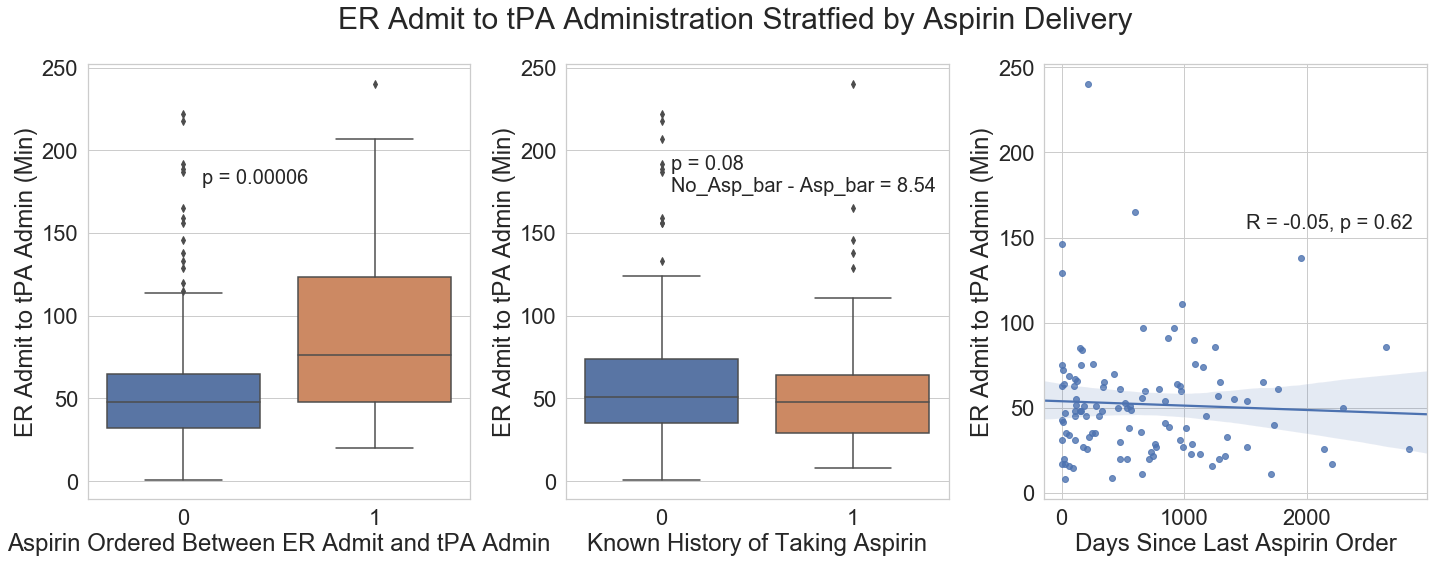

In [134]:
# Create figs
sns.set(style="whitegrid", font_scale=2.0)
fig1 = plt.figure(figsize=(24, 8))
fig1.suptitle('ER Admit to tPA Administration Stratfied by Aspirin Delivery', fontsize=30)

ax1 = fig1.add_subplot(1, 3, 1)
ax1 = sns.boxplot(x="aspirin_ord_during_admit", y="time_to_tPA", data=df_labels)
df_asp_at_admit = df_labels[df_labels['aspirin_ord_during_admit'] == 1]
df_no_asp_at_admit = df_labels[df_labels['aspirin_ord_during_admit'] == 0]
t, p = ttest_ind(df_asp_at_admit['time_to_tPA'], df_no_asp_at_admit['time_to_tPA'])
ax1.text(0.1, 180,'p = %.5f' % p, fontsize=20)
ax1.set_xlabel('Aspirin Ordered Between ER Admit and tPA Admin')
ax1.set_ylabel('ER Admit to tPA Admin (Min)')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax2 = fig1.add_subplot(1, 3, 2)
ax2 = sns.boxplot(x="prior_asprin_order", y="time_to_tPA", data=df_labels)
df_asp = df_labels[df_labels['prior_asprin_order'] == 1]
df_no_asp = df_labels[df_labels['prior_asprin_order'] == 0]
diff_in_mean =  np.mean(df_no_asp['time_to_tPA']) - np.mean(df_asp['time_to_tPA'])
t, p = ttest_ind(df_asp['time_to_tPA'], df_no_asp['time_to_tPA'])
ax2.text(0.05, 175,'p = %.2f\nNo_Asp_bar - Asp_bar = %.2f' % (p, diff_in_mean), fontsize=20)
ax2.set_xlabel('Known History of Taking Aspirin')
ax2.set_ylabel('ER Admit to tPA Admin (Min)')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax3 = fig1.add_subplot(1, 3, 3)
ax3 = sns.regplot(x="days_since_last_aspirin_order", y="time_to_tPA", data=df_asp)
pearson, pval = pearsonr(df_asp['days_since_last_aspirin_order'], df_asp['time_to_tPA'])
ax3.text(1500, 155,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax3.set_xlabel('Days Since Last Aspirin Order')
ax3.set_ylabel('ER Admit to tPA Admin (Min)')


fig1.subplots_adjust(wspace=0.25)

## Finally Looking at Vitals (Blood Pressure, Glasgow Coma, Heart Rate, Temp, Urine)

Nothing but glasgow coma score is significantly associated with time from admit until tPA administration

Text(0, 0.5, 'ER Admit to tPA Admin (Min)')

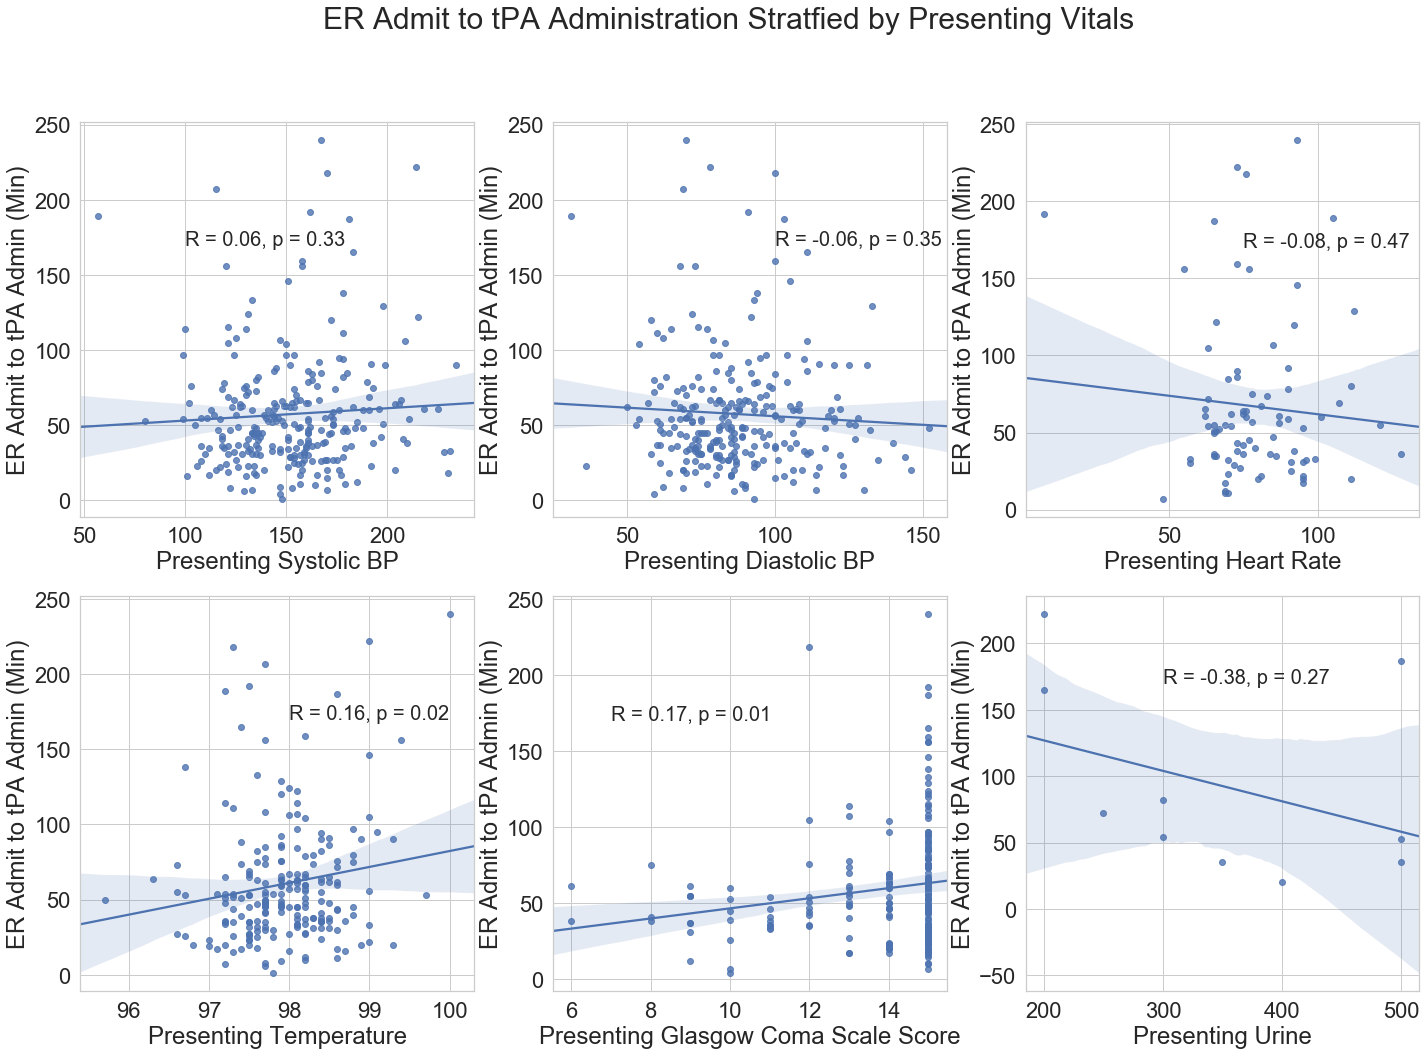

In [145]:
# Create figs
sns.set(style="whitegrid", font_scale=2.0)
fig1 = plt.figure(figsize=(24, 16))
fig1.suptitle('ER Admit to tPA Administration Stratfied by Presenting Vitals', fontsize=30)

df_bp_s = df_labels[df_labels['Systolic_BP'].notna()]
ax1 = fig1.add_subplot(2, 3, 1)
ax1 = sns.regplot(x="Systolic_BP", y="time_to_tPA", data=df_bp_s)
pearson, pval = pearsonr(df_bp_s['Systolic_BP'], df_bp_s['time_to_tPA'])
ax1.text(100, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax1.set_xlabel('Presenting Systolic BP')
ax1.set_ylabel('ER Admit to tPA Admin (Min)')

df_bp_d = df_labels[df_labels['Diastolic_BP'].notna()]
ax2 = fig1.add_subplot(2, 3, 2)
ax2 = sns.regplot(x="Diastolic_BP", y="time_to_tPA", data=df_bp_d)
pearson, pval = pearsonr(df_bp_d['Diastolic_BP'], df_bp_d['time_to_tPA'])
ax2.text(100, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax2.set_xlabel('Presenting Diastolic BP')
ax2.set_ylabel('ER Admit to tPA Admin (Min)')

df_hr = df_labels[df_labels['Heart Rate'].notna()]
ax3 = fig1.add_subplot(2, 3, 3)
ax3 = sns.regplot(x="Heart Rate", y="time_to_tPA", data=df_hr)
pearson, pval = pearsonr(df_hr['Heart Rate'], df_hr['time_to_tPA'])
ax3.text(75, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax3.set_xlabel('Presenting Heart Rate')
ax3.set_ylabel('ER Admit to tPA Admin (Min)')

df_temp = df_labels[df_labels['Temp'].notna()]
ax4 = fig1.add_subplot(2, 3, 4)
ax4 = sns.regplot(x="Temp", y="time_to_tPA", data=df_temp)
pearson, pval = pearsonr(df_temp['Temp'], df_temp['time_to_tPA'])
ax4.text(98, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax4.set_xlabel('Presenting Temperature')
ax4.set_ylabel('ER Admit to tPA Admin (Min)')

df_coma = df_labels[df_labels['Glasgow Coma Scale Score'].notna()]
ax5 = fig1.add_subplot(2, 3, 5)
ax5 = sns.regplot(x="Glasgow Coma Scale Score", y="time_to_tPA", data=df_coma)
pearson, pval = pearsonr(df_coma['Glasgow Coma Scale Score'], df_coma['time_to_tPA'])
ax5.text(7, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax5.set_xlabel('Presenting Glasgow Coma Scale Score')
ax5.set_ylabel('ER Admit to tPA Admin (Min)')

df_urine = df_labels[df_labels['Urine'].notna()]
ax6 = fig1.add_subplot(2, 3, 6)
ax6 = sns.regplot(x='Urine', y="time_to_tPA", data=df_urine)
pearson, pval = pearsonr(df_urine['Urine'], df_urine['time_to_tPA'])
ax6.text(300, 170,'R = %.2f, p = %.2f' % (pearson, pval), fontsize=20)
ax6.set_xlabel('Presenting Urine')
ax6.set_ylabel('ER Admit to tPA Admin (Min)')


### Do a Glasgow Coma Scale Score JointPlot

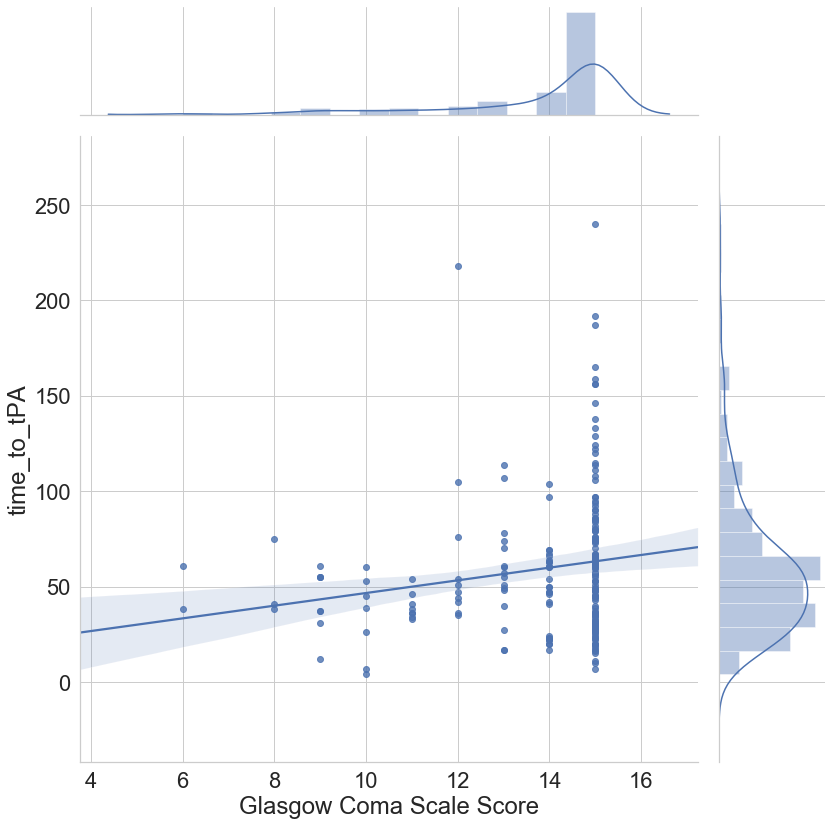

In [136]:
df_coma = df_labels[df_labels['Glasgow Coma Scale Score'].notna()]
ax5 = sns.jointplot(x="Glasgow Coma Scale Score", y="time_to_tPA", data=df_coma, kind='reg', height=12)
pearson, pval = pearsonr(df_coma['Glasgow Coma Scale Score'], df_coma['time_to_tPA'])
# ax5.text(7, 170,'R = %.2f, p = %.3f' % (pearson, pval), fontsize=20)
# ax5.set_xlabel('Presenting Glasgow Coma Scale Score')
# ax5.set_ylabel('ER Admit to tPA Admin (Min)')

## Fit Multiple Regression

In [137]:
# Inpute features we want in our model that need it
df_labels[['Glasgow Coma Scale Score', 'Heart Rate', 'Temp', 'Urine', 'Systolic_BP', 'Diastolic_BP']] = df_labels[['Glasgow Coma Scale Score', 'Heart Rate', 'Temp', 'Urine', 'Systolic_BP', 'Diastolic_BP']].fillna(df_labels[['Glasgow Coma Scale Score', 'Heart Rate', 'Temp', 'Urine', 'Systolic_BP', 'Diastolic_BP']].mean())

In [138]:
from statsmodels.regression.linear_model import OLS
formula = """time_to_tPA ~ age + C(gender) + C(canonical_ethnicity) + C(canonical_race) + history_of_afib + aspirin_ord_during_admit + prior_asprin_order + Q("Glasgow Coma Scale Score") + Q("Heart Rate") + Temp + Urine + Systolic_BP + Diastolic_BP """
model = OLS.from_formula(formula, data=df_labels)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            time_to_tPA   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.056
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           4.97e-05
Time:                        20:42:23   Log-Likelihood:                -1311.4
No. Observations:                 263   AIC:                             2661.
Df Residuals:                     244   BIC:                             2729.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               -661.6337    432.557     -1.530      0.127   -1513.655     190.388
C(gender)[T.Male]                        -10.6953      4.763     -2.246      0.026     -20.077      -1.314
C(canonical_ethnicity)[T.Non-Hispanic]   -13.2908     11.811     -1.125      0.262     -36.555       9.973
C(canonical_ethnicity)[T.Unknown]         -4.1301     14.837     -0.278      0.781     -33.356      25.096
C(canonical_race)[T.Black]                 3.7388     11.977      0.312      0.755     -19.853      27.331
C(canonical_race)[T.Native American]      22.7346     40.067      0.567      0.571     -56.186     101.655
C(canonical_race)[T.Other]                12.1540     12.778      0.951      0.342     -13.014      37.322
C(canonical_race)[T.Pacific Islander]     -3.2911     20.403     -0.161      0.872     -43.480      36.898
C(canonical_race)[T.Unknown]              -4.1301     14.837     -0.278      0.781     -33.356      25.096
C(canonical_race)[T.White]                11.0284      7.779      1.418      0.158      -4.294      26.351
age                                       -0.0598      0.191     -0.314      0.754      -0.435       0.316
history_of_afib                           -6.1427      6.305     -0.974      0.331     -18.562       6.277
aspirin_ord_during_admit                  39.2856     10.589      3.710      0.000      18.428      60.144
prior_asprin_order                        -6.1045      5.166     -1.182      0.238     -16.280       4.071
Q("Glasgow Coma Scale Score")              3.3302      1.418      2.349      0.020       0.538       6.123
Q("Heart Rate")                           -0.2762      0.239     -1.155      0.249      -0.747       0.195
Temp                                       7.8563      4.368      1.799      0.073      -0.748      16.460
Urine                                     -0.2254      0.105     -2.147      0.033      -0.432      -0.019
Systolic_BP                                0.1399      0.096      1.458      0.146      -0.049       0.329
Diastolic_BP                              -0.0427      0.144     -0.296      0.767      -0.326       0.241
==============================================================================
Omnibus:                       88.266   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.098
Skew:                           1.483   Prob(JB):                     3.32e-57
Kurtosis:                       6.865   Cond. No.                     2.07e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-31. This

In [139]:
pvals = results.pvalues
coeff = results.params
conf_lower = results.conf_int()[0]
conf_higher = results.conf_int()[1]

results_df = pd.DataFrame({"pvals":pvals,
                           "coeff":coeff,
                           "conf_lower":conf_lower,
                           "conf_higher":conf_higher
                            })

#Reordering...
results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]

In [140]:
results_df.sort_values(by="pvals")

,coeff,pvals,conf_lower,conf_higher
aspirin_ord_during_admit,39.285583,0.000257,18.427643,60.143522
"Q(""Glasgow Coma Scale Score"")",3.330183,0.019617,0.537815,6.122551
C(gender)[T.Male],-10.695302,0.025623,-20.076554,-1.314050
Urine,-0.225429,0.032741,-0.432200,-0.018658
Temp,7.856344,0.073318,-0.747536,16.460225
Intercept,-661.633724,0.127414,-1513.655217,190.387768
Systolic_BP,0.139887,0.146089,-0.049081,0.328855
C(canonical_race)[T.White],11.028365,0.157552,-4.294225,26.350955
prior_asprin_order,-6.104517,0.238473,-16.279868,4.070834
"Q(""Heart Rate"")",-0.276235,0.249337,-0.747442,0.194972
